In [1]:
# %%

ver = "v1.0.2"

ns = range(4, 300)
"""the range of n to calculate within current run"""

min_min_count = 20
"""
this value determines the minimum occurence of a minimum solution
before it is deemed as a global minimum
"""

max_task_queue_length = 32768

out_base_path = f"out/{ver}/min_potential"

sqlite3_db_path = f"{out_base_path}/db.sqlite3"

solver_path = f"release/{ver}/solver/SolverMinPotentialNaive.o3.out"

txt_dump_path = f"{out_base_path}/txt_dump/"

# %% init
import os
os.makedirs(out_base_path, exist_ok=True)
os.makedirs(txt_dump_path, exist_ok=True)

import sqlite3
if not os.path.exists(sqlite3_db_path):
  con = sqlite3.connect(sqlite3_db_path)
  cur = con.cursor()
  cur.execute("CREATE TABLE record(n INT, seed INT, value REAL, step INT, diff REAL);")
  cur.execute("CREATE UNIQUE INDEX idx_n_seed ON record (n, seed);")
  cur.execute("CREATE INDEX idx_n ON record (n);")
  cur.execute("CREATE INDEX idx_value ON record (value);")
  cur.execute("CREATE INDEX idx_seed ON record (seed);")
  con.close()

con = sqlite3.connect(sqlite3_db_path)
cur = con.cursor()


# %%
def get_dict_with_default(d, n, default=0):
  if n in d:
    return d[n]
  else:
    d[n] = default
    return default
  
import tqdm

def get_status(
  ns=None,
  gen_missed_tasks=False
):
  print("get_status")

  total_cnts = {}
  min_cnts = {}
  min_vals = {}
  min_val_seeds = {}

  missed_tasks = []

  if not ns:
    ns = [n[0] for n in cur.execute("SELECT DISTINCT n FROM record;").fetchall()]
  for n in tqdm.tqdm(ns):
    total_cnt_n = cur.execute(f"SELECT COUNT(n) FROM record WHERE n={n};").fetchone()[0]
    total_cnts[n] = total_cnt_n
    if total_cnt_n == 0:
      continue
    min_val_n = cur.execute(f"SELECT MIN(value) FROM record WHERE n={n};").fetchone()[0]
    rounded_min_val_n = round(min_val_n, 7)
    min_vals[n] = rounded_min_val_n
    min_cnts[n] = cur.execute(f"SELECT COUNT(n) FROM record WHERE n={n} AND value<{min_val_n+1e-7};").fetchone()[0]
    # min_cnts[n] = cur.execute(f"SELECT COUNT(n) FROM record WHERE n={n} AND ROUND(value, 7)={rounded_min_val_n};").fetchone()[0]
    min_val_seeds[n] = cur.execute(f"SELECT seed FROM record WHERE n={n} AND value={min_val_n};").fetchone()[0]
    if gen_missed_tasks:
      max_seed_n = cur.execute(f"SELECT MAX(seed) FROM record WHERE n={n}").fetchone()[0]
      if max_seed_n != total_cnt_n-1:
        missed_tasks_cnt_n = max_seed_n + 1 - total_cnt_n
        print(f"missing record of n={n}: {missed_tasks_cnt_n}")
        seed = total_cnt_n-1
        pbar = tqdm.tqdm(total=missed_tasks_cnt_n)
        while missed_tasks_cnt_n != 0:
          if cur.execute(f"SELECT 1 FROM record WHERE n={n} AND seed={seed};").fetchone() is None:
            missed_tasks_cnt_n -= 1
            missed_tasks.append((n, seed, ""))
            pbar.update(1)
          seed -= 1
  
  return total_cnts, min_cnts, min_vals, min_val_seeds, missed_tasks

total_cnts, min_cnts, min_vals, min_val_seeds, missed_tasks = get_status(ns, gen_missed_tasks=True)

get_status


100%|██████████| 296/296 [00:45<00:00,  6.46it/s] 


In [2]:
import pandas as pd
pd.set_option('display.max_rows', None)
df = pd.DataFrame(min_vals.items(), columns=["n", "min_potential"]).set_index("n")
df["path"] = df.apply(lambda x: f"out/v1.0.2/min_potential/txt_dump/{x.name}.txt", axis=1)
df

,min_potential,path
n,,
4,3.674235,out/v1.0.2/min_potential/txt_dump/4.txt
5,6.474691,out/v1.0.2/min_potential/txt_dump/5.txt
6,9.985281,out/v1.0.2/min_potential/txt_dump/6.txt
7,14.452977,out/v1.0.2/min_potential/txt_dump/7.txt
8,19.675288,out/v1.0.2/min_potential/txt_dump/8.txt
9,25.759987,out/v1.0.2/min_potential/txt_dump/9.txt
10,32.716949,out/v1.0.2/min_potential/txt_dump/10.txt
11,40.596451,out/v1.0.2/min_potential/txt_dump/11.txt
12,49.165253,out/v1.0.2/min_potential/txt_dump/12.txt


<BarContainer object of 296 artists>

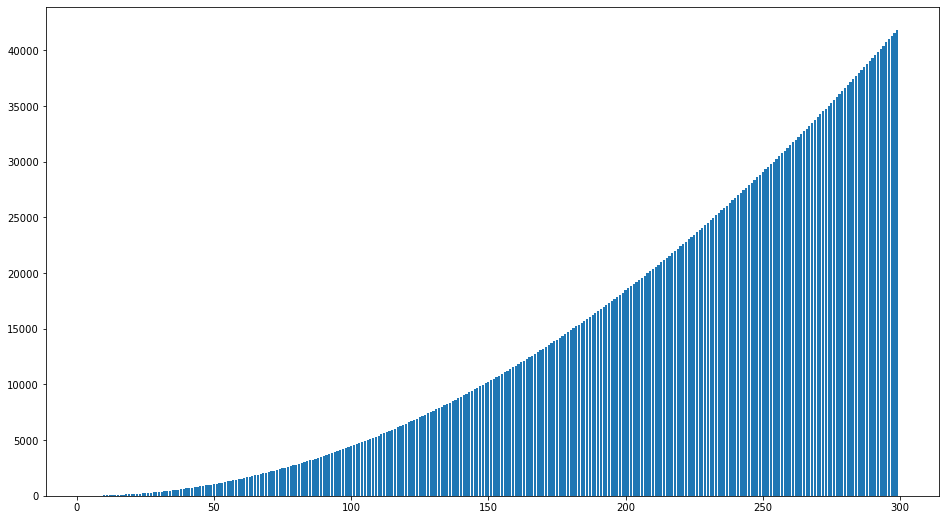

In [4]:
import matplotlib.pyplot as plt
import numpy as np
x = list(min_vals.keys())
y = list(min_vals.values())
plt.figure(figsize=(16,9))
plt.bar(
  x,
  y,
)